<a href="https://colab.research.google.com/github/dlwub/Density-Estimation-for-Financial-Market-Returns-Using-Normalizing-Flows/blob/master/Density_Estimation_for_Financial_Market_Returns_Using_Normalizing_Flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --force-reinstall tensorflow-probability==0.25.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1.17.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  

#### **Project Overview:** This project involves applying **normalizing flows** to model and estimate the probability distributions of financial market returns. Instead of assuming a normal probability distribution (which is inaccurate for financial data), we will learn a **flexible probability distribution** using normalizing flows.

**What is a Normalizing Flow?**

A normalizing flow is a technique that enables us to transform a simple probability distribution (e.g., a Gaussian) into a more complex distribution through a series of invertible transformations. By using a chain of such transformations, the flow allows us to model complex data distributions.

In a normalizing flow, the goal is to map a simple base distribution $p_Z(z)$ (e.g., normal distribution) to the complex data distribution $p_X(x)$. For a given data point $x$ in the transformed distribution, the flow transformation is modeled as:

$x = f(z; \theta)$ where $\theta$ represents the parameters of the non-linear transformation (neural network).

The relationship between the probability density functions of the $\text{data space}^{*} (p_Z(z)$ and the $\text{latent space}^{**} (p_X(x))$ is given by:

$
p_X(x) = p_z(f^{-1}(x; \theta)) \left| \det \frac{\partial f^{-1}(x, \theta)}{\partial x} \right|
\$

Where:
- $ f$ is the transformation function (invertible neural network).
- $ z$ is the data point in the latent space.
- $x$ is the transformed sample in the data space.
- $p_X$ and $p_Z$ are the probability densities of the data and latent variables, respectively.

The Jacobian determinant $\left| \det \frac{\partial f^{-1}}{\partial x} \right|$ scales the distribution according to the transformation's volume change.

#### The log-likelihood of a data point can be computed as:
$log p_X(x) = log p_Z(f^{-1}(x; \theta)) + log \left| \det \frac{\partial f^{-1}(x, \theta)}{\partial x} \right|$
#### However, $\left| \det \frac{\partial f^{-1}(x, \theta)}{\partial x} \right| = \left| \det \frac{\partial f(z, \theta)}{\partial z} \right|^{-1}$
#### Hence, we get $log p_X(x) = log p_Z(z) - log \left| \det J_f(z, \theta) \right|$

#### where $J_f(z, \theta) = \frac{\partial f}{\partial z}$ is the Jacobian of the transformation.

$ * \ \text{Data space:}$ is the original space where our data exists. For example, if we have images, the data space is where each image is represented by its pixels (e.g., a 28x28 pixel image would have 28x28 = 784 features or values). Essentially, the data space is where our raw data (such as images, text, or any other dataset) is represented.

$ ** \text{ Latent space:}$ is a transformed, often simplified, space where the model learns to represent the data in a more compact or useful way. We can think of it as a compressed or abstract version of the data that captures important features but in fewer dimensions. It is a kind of "hidden" space (hence the name latent space) that is harder to interpret directly but useful for machine learning models. The latent space allows the model to work with this compressed version of the data instead of the full, complex data space.

In other words, the latent space is where we define the simple distribution (usually Gaussian) and the data space where the transformed (or complex distribution) resides after applying the normalizing flows.

#### Import necessary libraries

In [20]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew, kurtosis
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

### Step 1. Load and preprocess financial data
#### We use S&P500 historical data

[*********************100%***********************]  1 of 1 completed


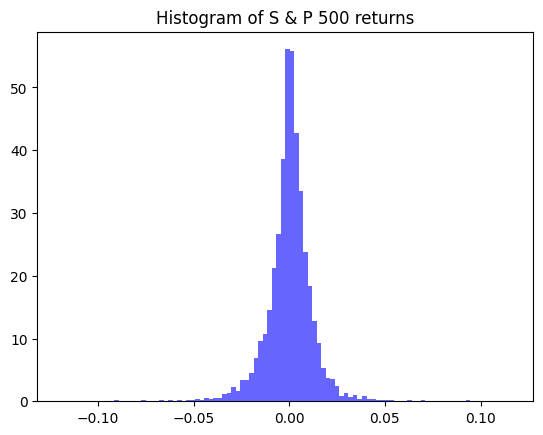

In [14]:
ticker = '^GSPC'
data = yf.download(ticker, start='2000-01-01', end='2025-01-01')
data['Return'] = data['Close'].pct_change().dropna()
returns = data['Return'].dropna()
plt.hist(returns, bins=100, density=True, alpha=0.6, color='b')
plt.title("Histogram of S & P 500 returns")
plt.show()

#### Standardize the data

In [21]:
scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns.values.reshape(-1, 1))
X_train, X_test = train_test_split(returns_scaled, test_size=0.2, shuffle=False)
results = {}

#### To determine whether the returns follow a Gaussian or t-distribution, we analuze their skewness, kurtosis, and Q-Q plots.

In [16]:
print(f'Skewness:{skew(returns)}')
print(f'Kurtosis:{kurtosis(returns)}')

Skewness:-0.16235197462270953
Kurtosis:10.184075008237489


#### The skewness (-0.16) is close to 0, which shows the distribution is nearly symmetric (returns have slightly negative more extreme negative values).
#### The kurtosis of a normal distribution is $\approx$ 3. The returns' kurtosis (10.18) is much higher, which suggests the returns have fat tails (i.e extreme price movements occur than expected under normal distribution).

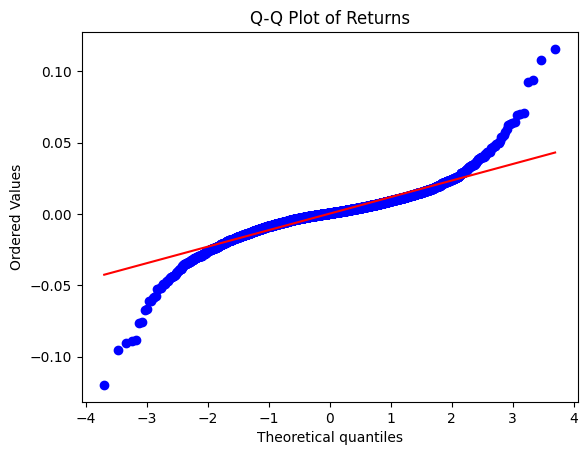

In [22]:
# Q-Q Plots
stats.probplot(returns, dist='norm', plot=plt)
plt.title("Q-Q Plot of Returns")
plt.show()

#### The tails deviate from the diagonal. Hence, normalizing flows will be of help.

### Step 2. Using RealNVP Normalizing Flow Model

## What is RealNVP?

RealNVP (Real-valued Non-Volume Preserving) model belongs to a broad class of normalizing flows called coupling flows, that uses affine coupling layers to build a series of invertible transformations. These transformations are designed to be computationally efficient and easy to invert, making them suitable for high-dimensional datasets.

RealNVP introduces an affine coupling layer that splits the input into two parts, and one part of the data is transformed based on the other part. In simple terms, the transformation is applied conditionally on one part of the input, and the rest of the data remains unchanged.

Mathematically, given a data point $\mathbf{x} = \mathbf{x}_A, \mathbf{x}_B$, the transformation is applied to one part say $\mathbf{x}_A$ conditioned on the other part $\mathbf{x}_B$:

$\mathbf{x}_A' = \mathbf{x}_A \cdot \exp(s(\mathbf{x}_B)) + t(\mathbf{x}_B)$

Here:
- $\mathbf s({x}_B)$ is a scaling function that computes how much $x_{B}$ should be scaled
- $\mathbf t({x}_B)$ is a translation function that shifts $x_{B}$
- The output $\mathbf{x}_A'$ is the transformed version of $\mathbf{x}_A$, while $\mathbf{x}_B$ remains unchanged.

RealNVP is designed to be invertible, which means we can efficiently compute both forward and backward transformations. Inverting the flow allows us to generate new samples by mapping points from the latent space back to the data space.

For the coupling layer:
$\mathbf{x}_A = \frac{\mathbf{x}_A' - t(\mathbf{x}_B)}{\exp(s(\mathbf{x}_B))}
$

This allows for easy sampling and likelihood evaluation, which is crucial for training.




### I. Define the Model

In [24]:
# Define model
tfd = tfp.distributions
tfb = tfp.bijectors

class RealNVP(keras.Model): # RealNVP inherits from keras Model
  def __init__(self, input_dim, hidden_dim, num_layers):
    super(RealNVP, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    self.masks = tf.constant(np.array([0, 1]*(input_dim//2) + [0]*(input_dim % 2)), dtype=tf.float32)
    self.scale_nets = [self._build_net(input_dim, hidden_dim, num_layers) for _ in range(2)]
    self.translate_nets = [self._build_net(input_dim, hidden_dim, num_layers) for _ in range(2)]

    self.prior = tfd.Normal(loc=0.0, scale=1.0)

  def _build_net(self, input_dim, hidden_dim, num_layers):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    for _ in range(num_layers - 2):
      x = layers.Dense(hidden_dim, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

  def call(self, x):
    log_det_jacobian = 0.0
    z = x
    mask = self.masks
    for i in range(2):
      s = self.scale_nets[i](z*mask)
      t = self.translate_nets[i](z*mask)
      z = z*(1 - mask) + (z*tf.exp(s) + t)* mask
      log_det_jacobian += tf.reduce_sum(s*mask, axis=1)
      mask = 1 - mask
    return z, log_det_jacobian

  def inverse(self, z):
    x = z
    mask = 1 - self.masks
    for i in reversed(range(2)):
      s = self.scale_nets[i](x*mask)
      t = self.translate_nets[i](x*mask)
      x = x*(1 - mask) + (x - t)*tf.exp(-s)*mask
      mask = 1- mask
    return x

  def log_prob(self, x):
    z, log_det_jacobian = self.call(x)
    log_prob = tf.reduce_sum(self.prior.log_prob(z), axis=1) + log_det_jacobian
    return log_prob

### II. Train the Model

In [25]:
#Training Loop
input_dim = 1
hidden_dim = 64
num_layers = 3
model = RealNVP(input_dim, hidden_dim, num_layers)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# Loss function
def loss_fun(model, x):
  log_prob = model.log_prob(x)
  return -tf.reduce_mean(log_prob)

# Training loop
epochs = 100
batch_size = 64
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)

for epoch in range(epochs):
  for i in range(0, len(X_train_tensor), batch_size):
    batch = X_train_tensor[i:i + batch_size]
    with tf.GradientTape() as tape:
      loss = loss_fun(model, batch)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  if (epoch + 1) %10 ==0:
    print(f'Epoch {epoch+1}/{epochs}, Loss:{loss.numpy():.4f}')

Epoch 10/100, Loss:-1.7966
Epoch 20/100, Loss:-2.4068
Epoch 30/100, Loss:-2.6896
Epoch 40/100, Loss:-2.9156
Epoch 50/100, Loss:-2.8192
Epoch 60/100, Loss:-3.1442
Epoch 70/100, Loss:-3.0170
Epoch 80/100, Loss:-3.2273
Epoch 90/100, Loss:-3.2477
Epoch 100/100, Loss:-3.3570


### III. Generate and compare returns

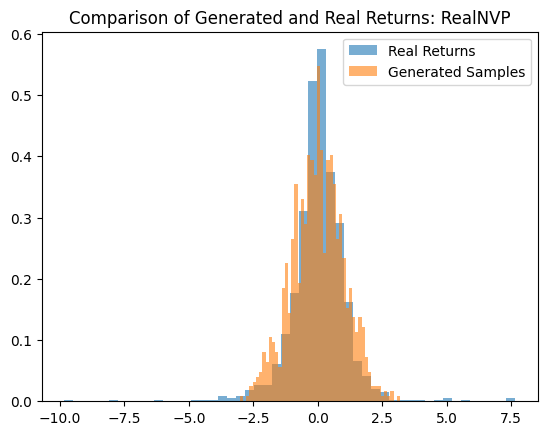

In [29]:
# Evaluate log-likelihood on the test set
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
train_log_prob = model.log_prob(X_train_tensor)
train_log_likelihood = tf.reduce_mean(train_log_prob).numpy()
test_log_prob = model.log_prob(X_test_tensor)
test_log_likelihood = tf.reduce_mean(test_log_prob).numpy()

# Sample from the learned distribution.
num_samples = 1000
z_samples = tf.random.normal((num_samples, input_dim))
generated_samples_NVP = model.inverse(z_samples).numpy()

# mean squared error between true and generated samples
mse = mean_squared_error(X_train[:num_samples], generated_samples_NVP)

results['RealNVP'] = {
        'train_log_likelihood': train_log_likelihood,
        'test_log_likelihood': test_log_likelihood,
        'mse': mse
    }

#Plot
plt.hist(X_test, bins=50, density=True, alpha=0.6, label='Real Returns')
plt.hist(generated_samples_NVP, bins=50, density=True, alpha=0.6, label='Generated Samples')
plt.title("Comparison of Generated and Real Returns: RealNVP")
plt.legend()
plt.show()

### Step 3. Using Masked Autoregressive Flow

## What is Masked Autoregressive Flow?
#### Masked autoregressive flow is a type of normalizing flow known as an autoregressive flow. It transforms a simple probability distribution (like a Gaussian) into a more complex one by applying a series of invertible transformations in an autoregressive manner. This means that each transformation depends only on the previously transformed variables.
#### Consider a random variable $x = (x_1, x_2, ..., x_D)$, where $D$ is the number of dimensions. Instead of transforming the entire vector at once, autoregressive models transform each $x_i$ one at a time, using only information from previous components: $x_i = f_i(z_i; \theta_i(x_{1:i-1}))$
#### Here:

#### $z_i$ is the latent (simpler) variable corresponding to $x_i$.

#### $f_i$ is a transformation function for $x_i$.

#### $\theta_i(x_{1:i-1})$ is a set of parameters that depend only on previous components ($x_1, ..., x_{i-1}$).

#### This step-by-step dependency structure is what makes the model autoregressive—each transformed variable depends only on the ones that came before it.

### Illustration with a simple example
#### Let’s say we want to model the probability distribution of two random variables, $x_1$ and $x_2$.

#### We first transform $x_1$ based on a simple function:
#### $x_1 = f_1(z_1) = z_1$

#### This means $z_1$ follows a normal distribution.

#### Next, we transform $x_2$ using an autoregressive function:

#### $x_2 = f_2(z_2; x_1) = z_2 + g(x_1)$
#### Here, $g(x_1)$ is a learned function that introduces dependence on $x_1$.

#### To sample new data, we first sample $z_1$ and $z_2$ from a simple Gaussian distribution and apply the transformations in order.
#### MAF (Masked Autoregressive Flow): Uses masking techniques to enforce the autoregressive structure in a neural network. This ensures that each variable
#### $x_i$ only depends on previously transformed variables.
### How Masking Works
#### In standard neural network, a layer computes its output as $h = W\cdot x + b$ where:
* $W$ is the weight matrix
* $x$ is the input vector
* $b$ is the bias vector
#### To enforce an autoregressive structure, we modify the weight matrix $W$ usinmg a mask matrix $M$:
#### $h = (M ⊙ W)\cdot x + b$
#### where:
#### * M is a binary matrix (containing 0s and 1s) that specifies which weights are allowed
#### * $\odot$ represents element-wise multiplication.
#### This mask is designed in a way that ensures each $x_i$ depends only on $x_1, x_2, ..., x_{i-1}$.
#### **Example:** Consider a simple example where we have three variables $x_1, x_2$, and $x_3$. Let the mask matrix be $M = \begin{bmatrix}
1 & 0 & 0 \\
1 & 1 & 0 \\
1 & 1 & 1
\end{bmatrix}$.
#### This ensures that
#### * $x_1$ doesn't depend on anything
#### * $x_2$ depends only on $x_1$
#### * $x_3$ depends on $x_1$ and $x_2$



### I. Define the Model

In [30]:
class MaskedDense(layers.Layer):
  def __init__(self, units, mask_type, **kwargs):
    super(MaskedDense, self).__init__(**kwargs)
    self.units = units
    self.mask_type = mask_type

  def build(self, input_shape):
    self.kernel = self.add_weight(
        shape=(input_shape[-1], self.units),
        initializer='random_normal',
        trainable=True
    )

    self.bias = self.add_weight(shape=(self.units,), initializer='zeros', trainable=True)
    self.input_dim = input_shape[-1]

    mask = np.ones((self.input_dim, self.units), dtype=np.float32)
    if self.mask_type=="A":
      mask[self.input_dim - 1, :] = 0
    elif self.mask_type=="B":
      mask[:self.input_dim - 1, :] = 1
    self.mask = tf.constant(mask)

  def call(self, inputs):
    return tf.matmul(inputs, self.kernel*self.mask) + self.bias

class MAF(keras.Model):
  def __init__(self, input_dim, hidden_dim, num_layers):
    super(MAF, self).__init__()
    self.input_dim = input_dim
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    self.transforms = []
    for i in range(num_layers):
      self.transforms.append(self._build_transform())

    self.prior = tfd.Normal(loc=0.0, scale=1.0)

  def _build_transform(self):
    net = keras.Sequential([
            MaskedDense(self.hidden_dim, mask_type="A"),
            layers.ReLU(),
            layers.Dense(self.hidden_dim, activation='relu'),
            layers.Dense(self.input_dim * 2)  # Outputs scale and shift
        ])

        # Register net as a trainable layer
    self.__setattr__(f"net_{len(self.transforms)}", net)

    def transform(x):
      h = net(x)
      scale, translation = tf.split(h, num_or_size_splits=2, axis=-1)
      scale = tf.tanh(scale)
      shift_bijector = tfp.bijectors.Scale(scale=tf.exp(scale))
      scale_bijector = tfp.bijectors.Shift(shift=translation)
      bijector = tfp.bijectors.Chain([shift_bijector, scale_bijector])

      return tfd.TransformedDistribution(
          distribution=tfd.Normal(loc=x, scale=tf.exp(scale)),
          bijector=bijector
      )

    return transform

  def call(self, x):
    log_prob = tf.zeros_like(x)
    z = x
    for transform in self.transforms:
      dist = transform(z)
      log_prob += dist.log_prob(z)
      z = dist.sample()
    return log_prob

  def log_prob(self, x):
    log_prob = tf.zeros_like(x)
    z = x
    for transform in self.transforms:
      dist = transform(z)
      log_prob += dist.log_prob(z)
      z = dist.sample()
    return log_prob

  def sample(self, num_samples):
    z = tf.random.normal((num_samples, self.input_dim))
    x = z
    for transform in reversed(self.transforms):
      dist = transform(x)
      x = dist.distribution.sample()
    return x

### II. Train the Model

In [32]:
# Instantiate the model
input_dim = 1
hidden_dim = 64
num_layers = 3
model = MAF(input_dim, hidden_dim, num_layers)

# Optimizer
optimizer = keras.optimizers.Adam(learning_rate = 1e-3)

#Loss function
def loss_fn(model, x):
  log_prob = model.log_prob(x)
  return -tf.reduce_mean(log_prob)

# Training Loop
epochs = 100
batch_size = 64

X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)

for epoch in range(epochs):
  for i in range(0, len(X_train_tensor), batch_size):
    batch = X_train_tensor[i:i + batch_size]
    with tf.GradientTape() as tape:
      loss = loss_fn(model, batch)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  if(epoch +1)%10==0:
    print(f'Epoch [{epoch + 1}/{epochs}]: Loss:{loss.numpy():.4f}')

Epoch [10/100]: Loss:0.2059
Epoch [20/100]: Loss:-0.0805
Epoch [30/100]: Loss:-0.1408
Epoch [40/100]: Loss:-0.0794
Epoch [50/100]: Loss:-0.0564
Epoch [60/100]: Loss:-0.2298
Epoch [70/100]: Loss:-0.1083
Epoch [80/100]: Loss:-0.1281
Epoch [90/100]: Loss:-0.1241
Epoch [100/100]: Loss:-0.2481


### III. Generate and Compare Returns

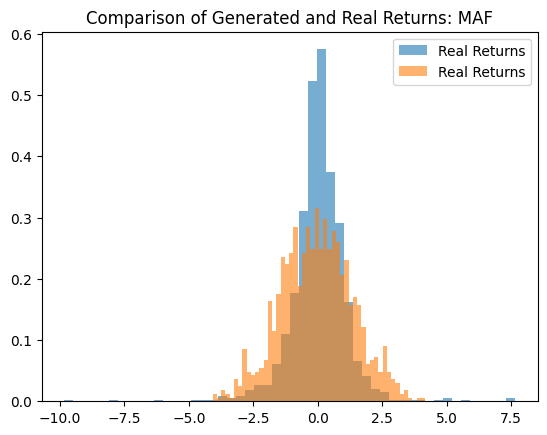

In [33]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
train_log_prob = model.log_prob(X_train_tensor)
train_log_likelihood = tf.reduce_mean(train_log_prob).numpy()
test_log_prob = model.log_prob(X_test_tensor)
test_log_likelihood = tf.reduce_mean(test_log_prob).numpy()

# Generate samples from the learned distribution
num_samples = 1000
generated_samples_MAF = model.sample(num_samples).numpy()

# mean squared error between true and generated samples
mse = mean_squared_error(X_train[:num_samples], generated_samples_MAF)

results['MAF'] = {
        'train_log_likelihood': train_log_likelihood,
        'test_log_likelihood': test_log_likelihood,
        'mse': mse
    }

# Plot
plt.hist(X_test, bins=50, density=True, alpha=0.6, label='Real Returns')
plt.hist(generated_samples_MAF, bins=50, density=True, alpha=0.6, label='Real Returns')
plt.title("Comparison of Generated and Real Returns: MAF")
plt.legend()
plt.show()

### Comparing the performance of RealNVP and MAF

In [34]:
# Print out final results
for model_name, result in results.items():
    print(f'\nResults for {model_name}:')
    print(f'  Train Log-Likelihood: {result["train_log_likelihood"]:.4f}')
    print(f'  Test Log-Likelihood: {result["test_log_likelihood"]:.4f}')
    print(f'  MSE of Generated Samples: {result["mse"]:.4f}')


Results for RealNVP:
  Train Log-Likelihood: 2.9633
  Test Log-Likelihood: 2.7660
  MSE of Generated Samples: 2.2791

Results for MAF:
  Train Log-Likelihood: -0.7070
  Test Log-Likelihood: -0.9520
  MSE of Generated Samples: 3.3726


### Interpretation
#### Log-likelihood quantifies how well the model represents the data, with a higher log-likelihood indicating that the model assigns greater probability to the observed data, making it a better fit.

#### Mean Squared Error (MSE) measures the discrepancy between the observed and generated data distributions. A lower MSE suggests that the generated samples closely resemble the real data, improving the model's generative performance.

#### Since RealNVP exhibits a higher log-likelihood and a lower MSE compared to MAF, it more effectively models the data distribution and generates samples that are closer to the real data. Therefore, RealNVP is the superior model in this case.

#### The third type of normalizing flow is Continuous Normalizing Flow (CNF). The following section presents its theoretical foundation without a code implementation.

## Continuous Normalizing Flows (CNFs)
#### Unlike discrete normilizing flows like coupling flows and autoregressive flows, which apply a sequence of invertible transformations to transform a simple distribution to a complex distribution, CNFs use continous time transformations.
#### Neural networks become powerful when they have many processing layers. Consider a neural network where each layer of processing generates an output given by the input vector with the addition of some parametrized non-linear function of that input vector $z^{(t+1)} = z^{(t)} + f(z^{(t)}, \theta)$ where
#### $t = 1, ..., T$ labels the layer in the network.
#### If we increase the number of layers while ensuring that the changes at each layer become correspomdingly smaller, the hidden-unit activation vector becomes a function $z(t)$ of a continuous variable $t$, and we can express the evolution of this vector through the network as a differential equation:
#### $\frac{dz(t)}{dt} = f(z(t), \theta)$ ... $(*)$
#### where $t$ is often referred to as 'time'. The formulation in (*) is known as a neural ordinary differential equation or neural ODE.
#### If we denote the input to the network by the vector $z(0)$, then the output $z(T)$ is given by $z(T) = z(0) + \int_{0}^{T} f(z(t), \theta) \, dt$
#### Here:
#### * $z(0) \sim p_Z(z)$ is the base distribution
#### * $z(T)$ represents the transformed variable corresponding to the target distribution $ p_X(x)$,  
#### This integral can be solved using numerical integration packages.

